### Looking for global fit (standard GLM-HMM) for Psytrack animals all together

In [1]:
# importing packages and modules
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

# code from summer project working with PWM data
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [10]:
#  animalsIDs = ['W060','W068','W073','W074','W075','W080','W081','W082','W088','W089']
animalsIDs = ['W060','W075','W081','W089']
pni_path = '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data'

In [11]:
# According to Jonathan's suggestions for fitting global GLM-HMM for all animals
# stage filter changed from 3 to 4
# cutoff changed from 10 to 50
firstAnimal = 'W060'
x, y = io_utils.prepare_design_matrices(rat_id=firstAnimal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=firstAnimal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4))

for animal in animalsIDs:
    if (animal != firstAnimal):
        xTemp, yTemp = io_utils.prepare_design_matrices(rat_id=animal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4, overwrite=False)
        sessIndTemp = list(io_utils.session_start(rat_id=animal, path=pni_path, psychometric=True, cutoff=100, stage_filter=4))
        x = np.concatenate((x,xTemp))
        y = np.concatenate((y,yTemp))
oneSessInd = [0,x.shape[0]]
print(oneSessInd)

# NOT TAKING INTO ACCOUNT TO BREAK FORWARD-BACKWARD AT EACH SESSION LIKE IRIS DOES
    

[0, 489249]


### K=1 GLM Fit

In [14]:
inits = 20
penaltyW=True
maxiter = 250

path = pni_path

N = x.shape[0]
D = x.shape[1]
C = 2 # only looking at binomial classes
K = 1

allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))
oneSessInd = [0,N]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

for i in range(0,inits):
    print("Init ", i)

    # global fit
    if (i%2 ==0):
        initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) 
    else:
        initP0, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['normal', (0,2)]) 
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(x, y,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, penaltyW=penaltyW) # sigma does not matter here
    
    np.save(f'../data_PWM/trainLl-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allLl)
    np.save(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allP)
    np.save(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allW)

    

Init  0
0
Init  1
0
Init  2
0
Init  3
0
Init  4
0
Init  5
0
Init  6
0
Init  7
0
Init  8
0
Init  9
0


KeyboardInterrupt: 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

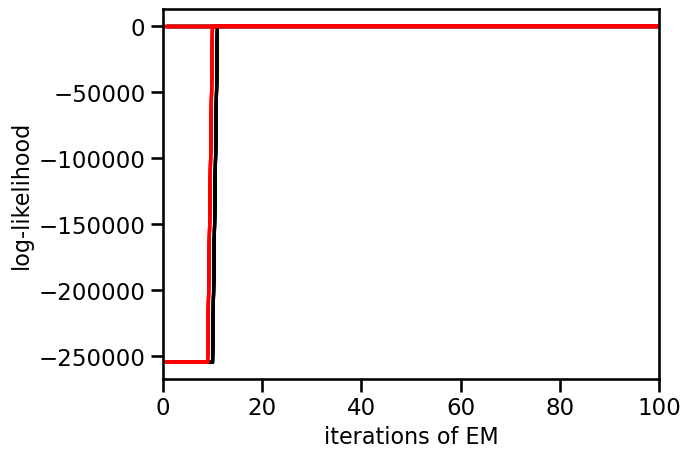

In [15]:
def plot_loglikelihoods(lls,maxdiff,ax,startix=5):
    '''
    Plot the trajectory of the log-likelihoods for multiple fits, identify how many top fits (nearly) match, and 
    color those trajectories in the plot accordingly
    '''
    
    # get the final ll for each fit
    final_lls = np.array([np.amax(lls[i,~np.isnan(lls[i,:])]) for i in range(lls.shape[0])])
    
    # get the index of the top ll
    bestix = np.argmax(final_lls)
    
    # compute the difference between the top ll and all final lls
    ll_diffs = final_lls[bestix] - final_lls
    
    # identify te fits where the difference from the top ll is less than maxdiff
    top_matching_lls = lls[ll_diffs < maxdiff,:]
    
    # plot
    ax.plot(np.arange(startix,lls.shape[1]),lls.T[startix:], color='black')
    ax.plot(top_matching_lls.T[startix:], color='red')
    ax.set_xlabel('iterations of EM', fontsize=16)
    ax.set_ylabel('log-likelihood', fontsize=16)
    
    return np.where(ll_diffs < maxdiff)[0] # return indices of best (matching) fits
fig, axes = plt.subplots(1)
axes.set_xlim(0,100)
plot_loglikelihoods(allLl,maxdiff=0.1,ax=axes,startix=5)

In [43]:
K = 1
allW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}.npy')
weightsGLM = allW[0]
print(weightsGLM.shape)

(489249, 1, 6, 2)


In [ ]:
# Find best init for GLM

#### K=2 GLM-HMM Fit with weight initializations from GLM + noise - 3 out of 6 options were top ones, same like Iris' global solutions

In [64]:
inits = 12
penaltyW=True
maxiter = 250

path = pni_path

N = x.shape[0]
D = x.shape[1]
C = 2 # only looking at binomial classes
K = 2

allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))
oneSessInd = [0,N]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)

weightsGLM_K2 = np.repeat(weightsGLM, 2, axis=1)
for i in range(0,inits):
    print("Init ", i)
    # global fit
    if (i%2 ==0):
        initP, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-1,1)]) 
        initW = initW0 + weightsGLM_K2
    else:
        initP, initW0 = dGLM_HMM.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['normal', (0,1)]) 
        initW = initW0 + weightsGLM_K2
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-3, penaltyW=penaltyW) # sigma does not matter here
    np.save(f'../data_PWM/trainLl-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allLl)
    np.save(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allP)
    np.save(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_penaltyW={penaltyW}', allW)

    

Init  0
0
Init  1
0
100
200
Init  2
0
Init  3
0
Init  4
0
100
200
Init  5
0


KeyboardInterrupt: 